# Comparison of Leading Models of Each Architecture on OVS1618

### Leading Models
- CTGAN: M5_R5
- TableGAN: M3_R5
- TVAE: M34_R4

## Importing necessary libraries

In [1]:
# Import libraries

import torch
import numpy as np

import os
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy.stats
from sklearn.metrics import mean_squared_error
from scipy.stats import bartlett
from scipy.stats import ttest_ind
from pathlib import Path


# Setting seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)

In [2]:
cwd = os.getcwd()

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [4]:
# Load cleaned 2016-2018 OVS datasets; replace NAs by -1
OVS1618 = pd.read_csv(str(Path(cwd).parents[0]) + '/Step1/Real Data/OVS1618v5_-1.csv')

In [5]:
OVS1618.head()

,month,Mode of Transport (m1),a1,a4,a5,r.int1,r.int2,b1a,b1b,b2,b3b,b6,b7a,b7b,b7c,b7c_cat,b8,b9a,b9b,b9c,b9c_cat,b10,b11,b12_1,b12_2,b12_3,b12_4,b12_9,b12_10,b12_11,b12_12,b12_13,b12_14,b12_15,b12number_1,b12number_1_cat,b12number_2,b12number_2_cat,b12number_4,b12number_4_cat,b12number_6,b12number_6_cat,b13a_111,Main POV - Leisure/Holiday (b13a_112),b13a_113,Main POV - Visiting Friends/Family (b13a_114),b13a_115,Main POV - Business (b13a_116),Main POV - Healthcare (b13a_117),Main POV - Education/Training/Workshop (b13a_118),Main POV - Others (b13a_119),b13b_1,b13b_2,b13b_3,b13b_4,b13b_5,b13b_6,b13b_7,b13b_8,b13b_9,b13b_10,b13b_11,b13b_12,b13b_13,b13b_14,b13b_15,b13b_771,b13b_21,b13b_22,b13b_23,b13b_24,b13b_25,b13b_772,b13b_31,b13b_32,b13b_33,b13b_34,b13b_773,b13b_41,b13b_42,b13b_43,b13b_44,b13b_45,b13b_774,b13b_51,b13b_52,b13b_53,b13b_775,b13b_61,b13b_62,b13b_63,b13b_64,b13b_65,b13b_66,b13b_67,b13b_68,b13b_776,b13b_120,b13b_121,b13b_122,b13b_996,b13b_firstmention,b13b_secondmention,b13b_thirdmention,b13b_fourthmention,b13b_fifthmention,b13b_sixthmention,b13b_seventhmention,b13b_eighthmention,Travel Package (c1a),tr.type,c1c,c1c_cat,c2,c4a_1,c4a_2,c4a_3,"Accommodation - Hotels (c4a_1, c4a_2, c4a_3)",c4a_4,c4a_5,c4a_6,c4a_7,c4a_8,"Accommodation - Others (c4a_4, c4a_5, c4a_7, c4a_8)",c4a_9,c4a_10,c4a_11,c4a_12,c4a_13,c4a_14,c4a_1mention,c4a_2mention,c4a_3mention,c4a_4mention,c4a_5mention,c4a_6mention,c4a_7mention,c4a_8mention,c4a_9mention,c4a_10mention,c4a_11mention,c4a_12mention,c4a_13mention,c4a_14mention,c4a_15mention,c4b_1,c4c_1,c4c_1_cat,c5,c5_cat,c6_1,c6_2,c6_3,c6_4,c6_5,c6_6,c6b_1_1,c6b_1_2,c6b_2_1,c6b_2_2,c6b_3_1,c6b_3_2,c6b_4_1,c6b_4_2,"Expenditure on Hawker Centre, Food Court or Coffee Shop (c6c_1.r)","Expenditure on Hawker Centre, Food Court or Coffee Shop (c6c_1.r)_cat",Expenditure on Casual Dining (c6c_2.r),Expenditure on Casual Dining (c6c_2.r)_cat,c6d,c6d_cat,c7a_1,c7a_2,c7b_1.r,c7b_1.r_cat,c7c,c7c_cat,c8b_2,c8b_4,c8b_8,c8b_10,c8b_1_4,c8b_1_7,c8b_1_8,c8b_1_9,c8b_1_10,c8b_3_1,c8b_3_2,c8b_3_3,c8b_3_4,c8b_3_5,c8b_3_6,c8b_3_8,c8b_3_9,c8b_3_10,c8b_5_5,c8b_11_4,c9,c10a_1,c10a_2,c10a_3,c10a_4,c10a_6,c10b_1_1,c10b_1_2,c10b_2_1,c10b_2_2,c10b_3_1,c10b_3_2,c10b_4_1,c10b_4_2,Expenditure on Sightseeing (c10c_1.r),Expenditure on Sightseeing (c10c_1.r)_cat,Expenditure on Attractions (c10c_2.r),Expenditure on Attractions (c10c_2.r)_cat,c10d,c10d_cat,c13_1,c13_2,c13_3,c13_5,c13_6,c13_8,c13_9,c13_10,c13_11,c13_12,c13_13,c13_14,c13_15,c13_21,c13_17,c13_19,c13_20,c13_22,c14.r,c14.r_cat,Expenditure on Fashion (t7.m.fash),Expenditure on Fashion (t7.m.fash)_cat,Expenditure on Healthcare & Wellness Products (t7.m.well),Expenditure on Healthcare & Wellness Products (t7.m.well)_cat,Expenditure on Confectionery & Food Items (t7.m.food),Expenditure on Confectionery & Food Items (t7.m.food)_cat,t7.m.gift,t7.m.gift_cat,t7.m.oth,t7.m.oth_cat,Expenditure on Other Shopping Items (t7.m.gift + t7.m.oth),Expenditure on Other Shopping Items (t7.m.gift + t7.m.oth)_cat,Expenditure on Shopping (t7.m.any),Expenditure on Shopping (t7.m.any)_cat,t7.fash,t7.well,t7.food,t7.gift,t7.oth,t7.any,c16,c16_cat,c17,f1,f2,f3,f4,f5,f7,hoteltier,Package Expenditure Per Person (c1b.r),Package Expenditure Per Person (c1b.r)_cat,b12b_1,b12b_1_cat,b12b_2,year,Expenditure on Accommodation (c4.tot.new),Expenditure on Accommodation (c4.tot.new)_cat,Expenditure on F&B (c6.tot.new),Expenditure on F&B (c6.tot.new)_cat,Expenditure on Transport (c7.tot.new),Expenditure on Transport (c7.tot.new)_cat,Expenditure on Sightseeing & Entertainment (c10.tot.new),Expenditure on Sightseeing & Entertainment (c10.tot.new)_cat,a2.r.10l,f7a_n,b12number_3_5,b12number_3_5_cat,b12number_7_8,b12number_7_8_cat,c8b_99,c8b_1,c8b_3,c8b_5,c8b_6,c8b_7,c8b_11
0,1,1,1,57,93,34,7,1,NaN,1,1.0,2,NaN,NaN,-1.0,1,2,NaN,NaN,-1.0,1,6,6,0,1,0,0,0,0,0,0,0,0,0,0.0,0,0.0,0,0.0,0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14.0,0.0,0.0,0.0

In [6]:
OVS1618.shape

(66030, 293)

In [7]:
# Total of 24 Benchmark variables

# List of 14 expenditure (continuous) variables 
list_expnd = ['Expenditure on Accommodation (c4.tot.new)',
              'Expenditure on F&B (c6.tot.new)',
              'Expenditure on Hawker Centre, Food Court or Coffee Shop (c6c_1.r)',
              'Expenditure on Casual Dining (c6c_2.r)',
              'Expenditure on Transport (c7.tot.new)', 
              'Expenditure on Sightseeing & Entertainment (c10.tot.new)',
              'Expenditure on Sightseeing (c10c_1.r)',
              'Expenditure on Attractions (c10c_2.r)',
              'Expenditure on Shopping (t7.m.any)',          
              'Expenditure on Healthcare & Wellness Products (t7.m.well)',
              'Expenditure on Confectionery & Food Items (t7.m.food)',
              'Expenditure on Fashion (t7.m.fash)',
              'Expenditure on Other Shopping Items (t7.m.gift + t7.m.oth)',
              'Package Expenditure Per Person (c1b.r)']

# List of 10 categorical variables
list_cat = ['Mode of Transport (m1)',
            'Main POV - Leisure/Holiday (b13a_112)',
            'Main POV - Visiting Friends/Family (b13a_114)',
            'Main POV - Business (b13a_116)',
            'Main POV - Healthcare (b13a_117)',
            'Main POV - Education/Training/Workshop (b13a_118)',
            'Main POV - Others (b13a_119)',
            'Travel Package (c1a)',
            'Accommodation - Hotels (c4a_1, c4a_2, c4a_3)',
            'Accommodation - Others (c4a_4, c4a_5, c4a_7, c4a_8)']

In [8]:
## continuous columns
with open(str(Path(cwd).parents[0]) + '/Step1/Real Data/continuous_columns.txt',"r+")   as f:
    con_cols = f.read().splitlines() 

#len(con_cols) #37

In [9]:
##categorical columns
with open(str(Path(cwd).parents[0]) + '/Step1/Real Data/categorical_columns.txt',"r+")   as f:
    cat_cols = f.read().splitlines() 
    
#len(cat_cols) #222

In [10]:
with open(str(Path(cwd).parents[0]) + '/Step1/Real Data/binary_categorical_columns.txt',"r+")   as f:
    cat_list = f.read().splitlines() 

#len(cat_list) #34

In [11]:
discrete_cols = cat_cols + cat_list
#len(discrete_cols) #256

In [12]:
## split data into training/validation/test
OVS1618_train_val, OVS1618_test = train_test_split(OVS1618, test_size=0.15, random_state=42)

In [13]:
OVS1618_train_val.shape # 85% of OVS1618 data

(56125, 293)

In [14]:
OVS1618_test.shape # 15% of OVS1618 data

(9905, 293)

## Load generated data

In [15]:
## list all continuous variables for which 0 is meaningful
column_list = ['b10','b11','b12number_1','b12number_2','b12number_3_5','b12number_4','b12number_6','b12number_7_8','c1c','c4c_1','b12b_1','b12b_2']

In [16]:
## clean synthethid data and test data
## replace NAs back and remove non-positive/positive values
def data_cleaning(df):
    df_new = df.copy()
    for expnd in con_cols:
        if expnd + '_cat' in df.columns:
            df_new[expnd] = df_new[expnd].mask(df_new[expnd+'_cat'] == 1)
        if expnd in column_list:
            df_new[expnd] = df_new[expnd].mask(df_new[expnd] < 0)
        else:
            df_new[expnd] = df_new[expnd].mask(df_new[expnd] <= 0)
    return df_new

In [17]:
## CTGAN Leading Model: Model 5 Run 5 (M5_R5) 
ctgan_samples = pd.read_csv(cwd + '/Synthetic Data/ctgan_model_5_PID16393_20210309_142940_sample.csv')
ctgan_samples_cleaned = data_cleaning(ctgan_samples)

In [18]:
## TableGAN Leading Model: Model 3 Run 5 (M3_R5)
tablegan_samples = pd.read_csv(cwd + '/Synthetic Data/tablegan_model_3_PID5466_20210306_220737_sample.csv')
tablegan_samples_cleaned = data_cleaning(tablegan_samples)

In [19]:
## TVAE Leading Model: Model 34 Run 4 (M34_R4)
tvae_samples = pd.read_csv(cwd + '/Synthetic Data/tvae_model_34_PID5074_20210305_165149_sample.csv')
tvae_samples_cleaned = data_cleaning(tvae_samples)

In [20]:
samples_cleaned=[ctgan_samples_cleaned,tablegan_samples_cleaned,tvae_samples_cleaned]

In [21]:
test_cleaned = data_cleaning(OVS1618_test)

In [22]:
case_details = ['CTGAN', 'TABLEGAN', 'TVAE']

# 1. Visualization (KDE plots, Bar charts and Boxplots)

In [23]:
case =  ['CTGAN', 'TABLEGAN', 'TVAE']

In [24]:
## KDE plots
def plots(original_data, synthetic_data, list_expnd):
    
    for i in np.arange(len(list_expnd)):
        fig,ax = plt.subplots(1, len(synthetic_data), figsize=(20, 5))
        col = list_expnd[i]
        prop = round(sum(original_data[col].isna())/len(original_data[col])*100,2)
        fig.suptitle(col + " " + str(prop) +'% NAs')
        for j in np.arange(len(synthetic_data)):
            ax[j].set_title(case[j])
            ax[j].set_xlabel(" ")
            sns.kdeplot(original_data[col],shade=True, ax=ax[j], label='Original')
            if len(synthetic_data[j][col].unique()) > 1:
                sns.kdeplot(synthetic_data[j][col],shade=True,ax=ax[j], label='Synthetic')
            ax[j].legend();
        plt.show()

In [25]:
## Bar plots
def plots_bar(original_data, synthetic_data, cat_cols):
    width = 0.1
    
    for i in np.arange(len(cat_cols)):
        fig,ax = plt.subplots(1, len(synthetic_data), figsize=(16, 5))
        col = cat_cols[i]
        xlab = np.asarray(original_data[col].value_counts(normalize=True).index)
        fig.suptitle(col)
        for j in np.arange(len(synthetic_data)):
            ax[j].set_title(case[j])
            ax[j].bar(xlab,original_data[col].value_counts(normalize=True), color='g', label='Original Data',width=width)
            ax[j].bar(xlab+width,synthetic_data[j][col].value_counts(normalize=True), color='b', label='Synthetic Data',width=width) 
            ax[j].legend();
        plt.show()

In [26]:
def boxplots4(original_data, synthetic_data, list_expnd):
    
    for i in np.arange(len(list_expnd))[::2]:
        fig,ax = plt.subplots(1, 2, figsize=(16, 5))
        col1 = list_expnd[i]
        col2 = list_expnd[i+1]
        prop1 = round(sum(original_data[col1].isna())/len(original_data[col1])*100,2)
        ax[0].set_title(col1 + " " + str(prop1) +'% NAs')
        df1 = pd.DataFrame({'Original': original_data[col1],
                       'CTGAN_M5_R5':synthetic_data[0][col1],
                          'TABLEGAN_M3_R5':synthetic_data[1][col1],
                           'TVAE_M34_R4':synthetic_data[2][col1]})
        sns.boxplot(x="variable", y="value", data=pd.melt(df1),ax=ax[0],showmeans=True, meanprops={"marker":"s",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black"})
                      #"markersize":"8"})

       # ax[0].legend();
        prop2 = round(sum(original_data[col2].isna())/len(original_data[col2])*100,2)
        ax[1].set_title(col2 + " " + str(prop2) +'% NAs')
              
        df2 = pd.DataFrame({'Original': original_data[col2],
                       'CTGAN_M5_R5':synthetic_data[0][col2],
                          'TABLEGAN_M3_R5':synthetic_data[1][col2],
                           'TVAE_M34_R4': synthetic_data[2][col2]})
        sns.boxplot(x="variable", y="value", data=pd.melt(df2),ax=ax[1],showmeans=True,meanprops={"marker":"s",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black"})
                      #"markersize":"8"
       # ax[1].legend();
        plt.show()

## 1.1 KDE plots for OVS1618_test data vs Synthetic data under three leading models (continuous benchmark variables)

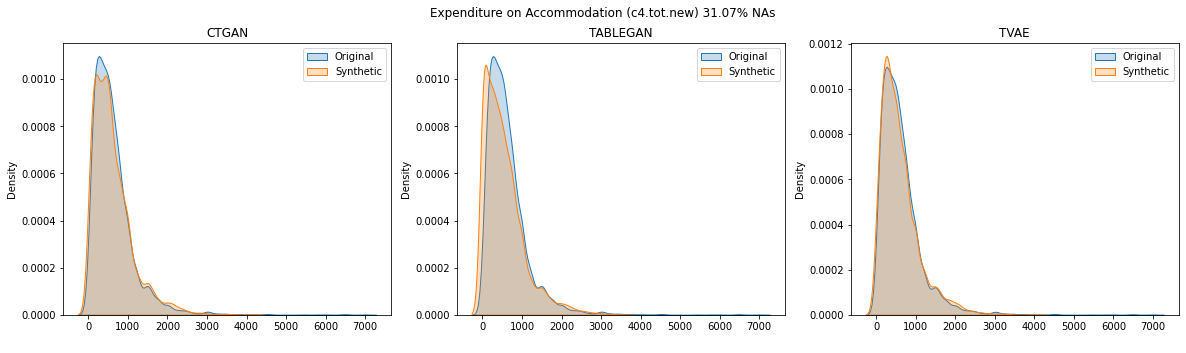

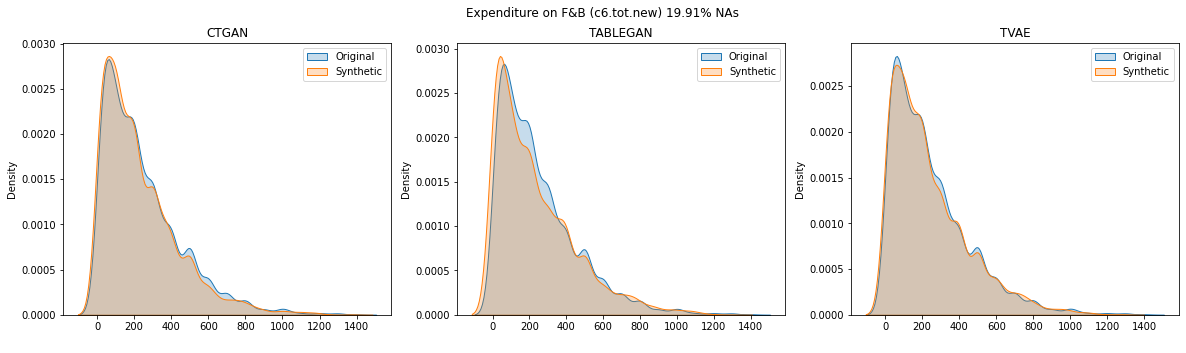

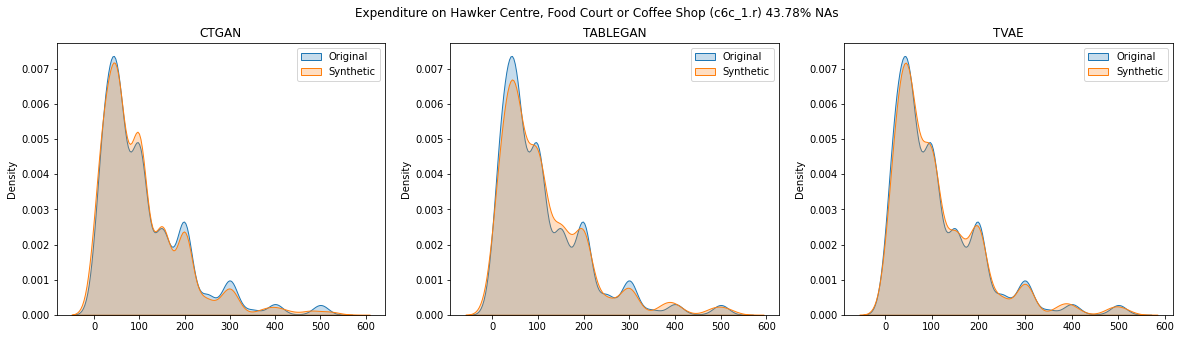

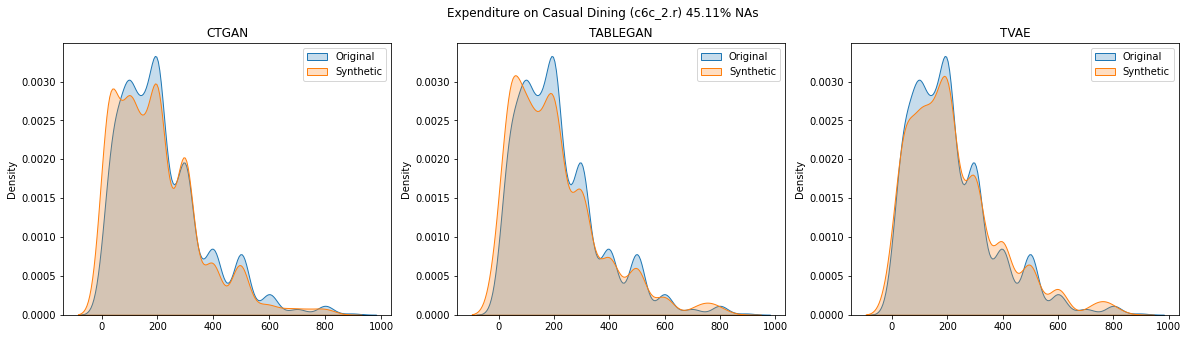

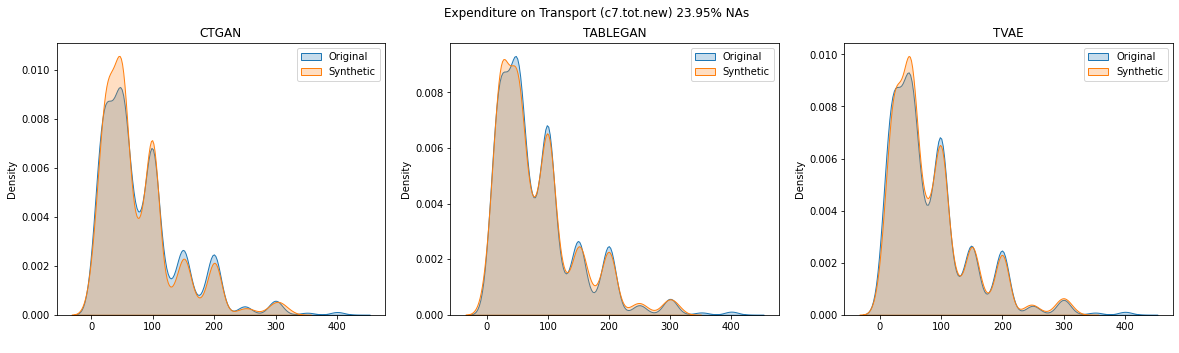

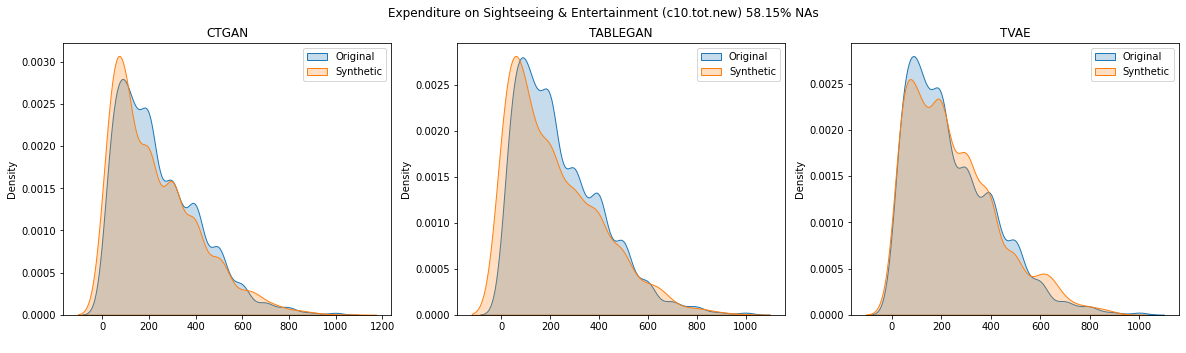

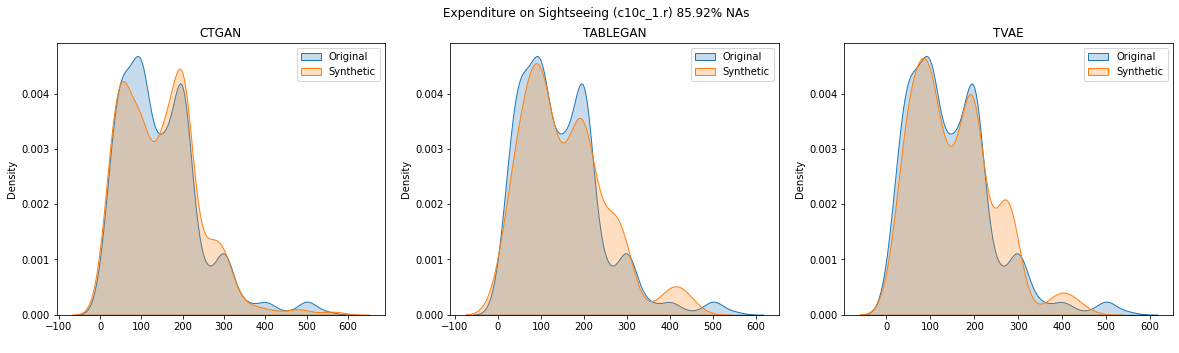

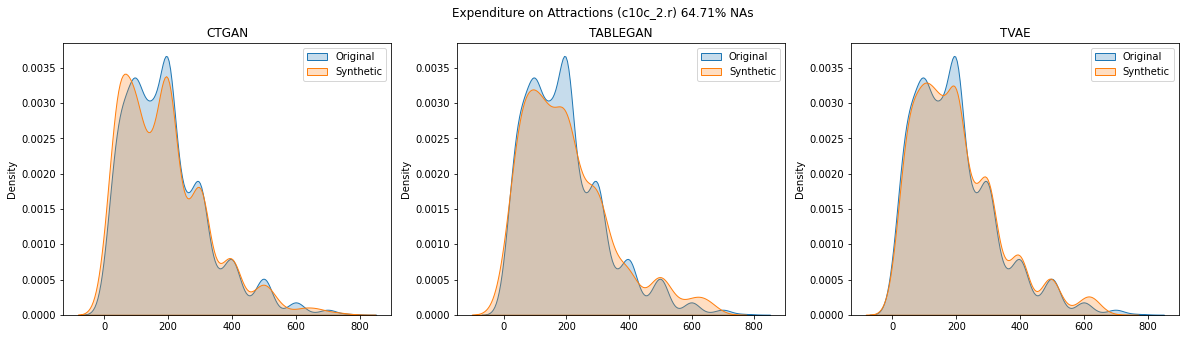

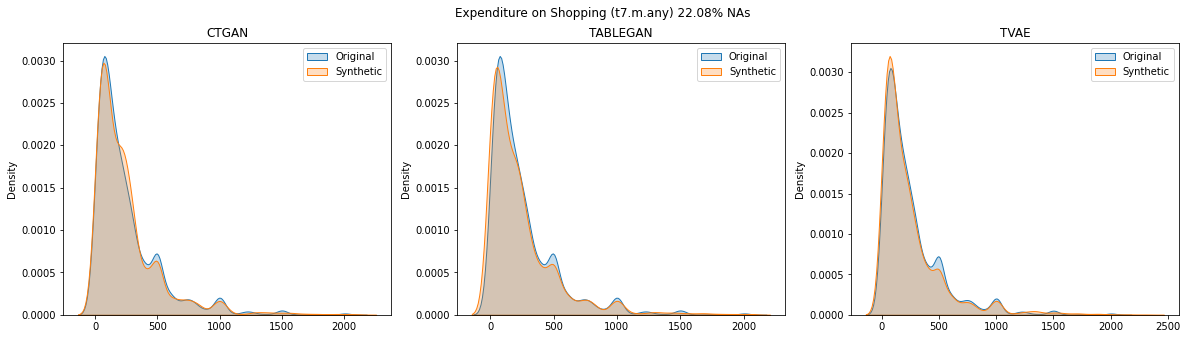

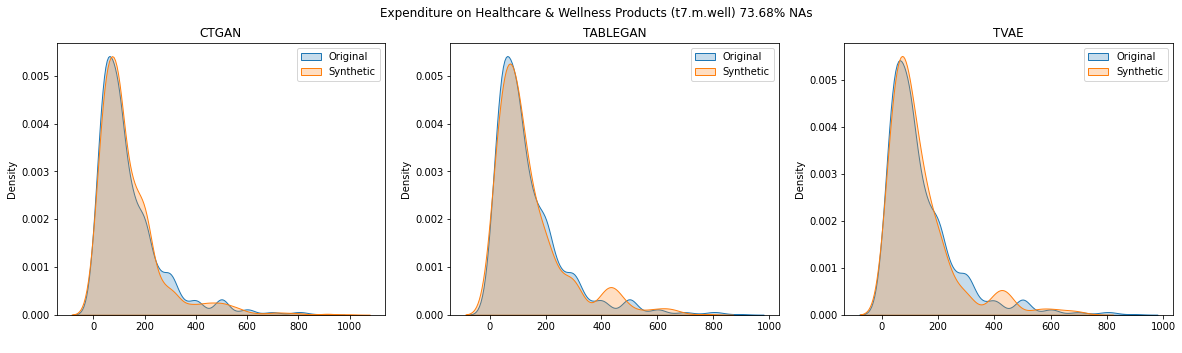

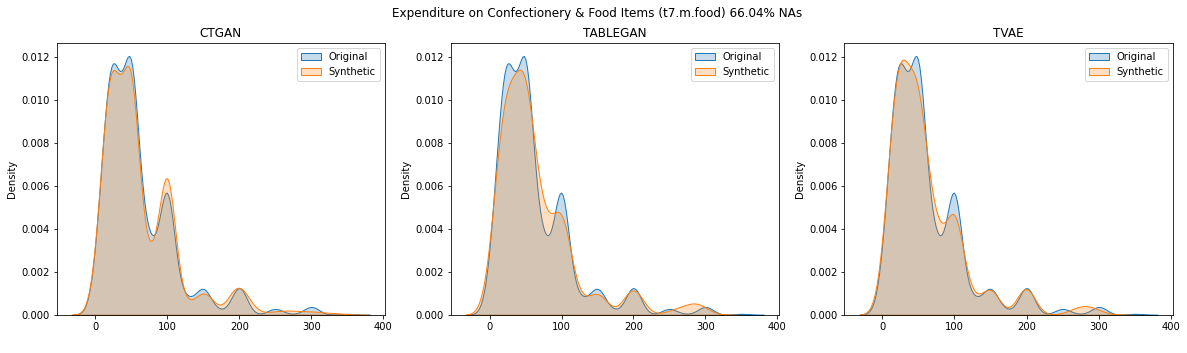

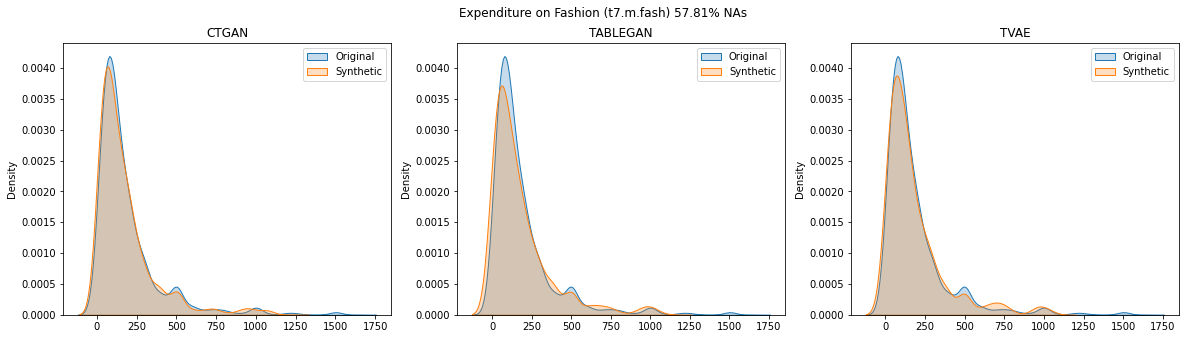

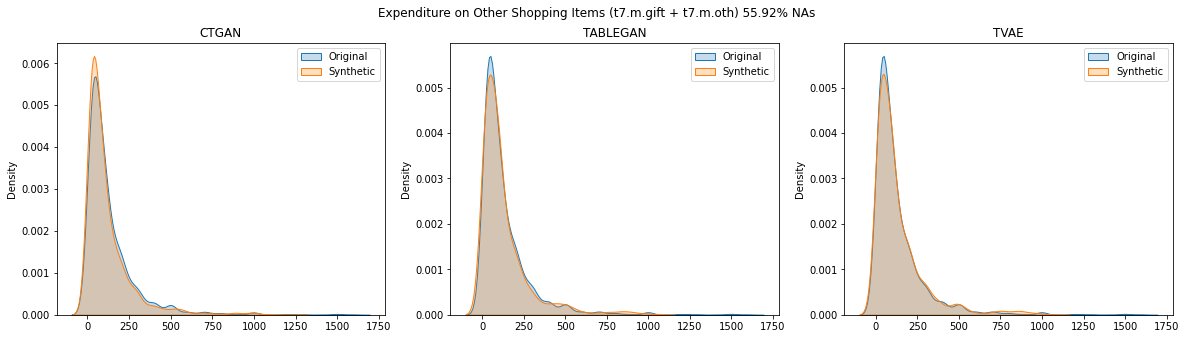

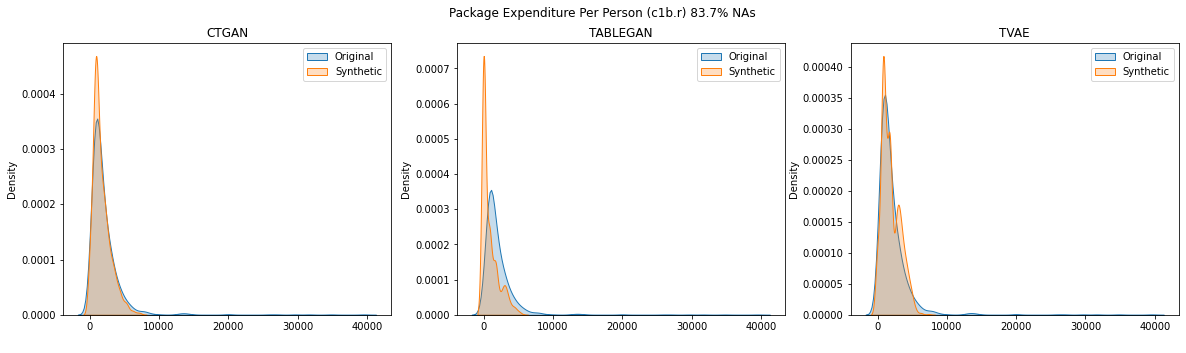

In [27]:
plots(test_cleaned,samples_cleaned,list_expnd)

## 1.2 Boxplots for OVS1618_test data vs Synthetic data under three leading models (continuous benchmark variables)

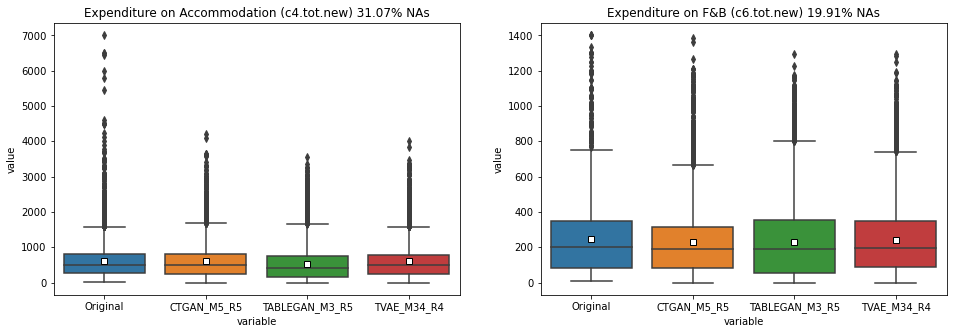

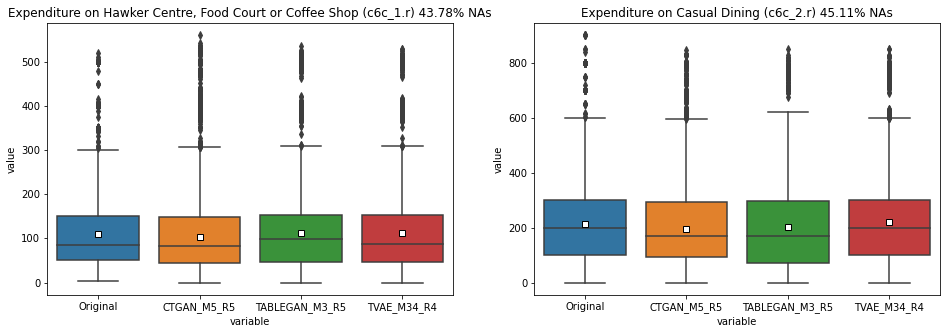

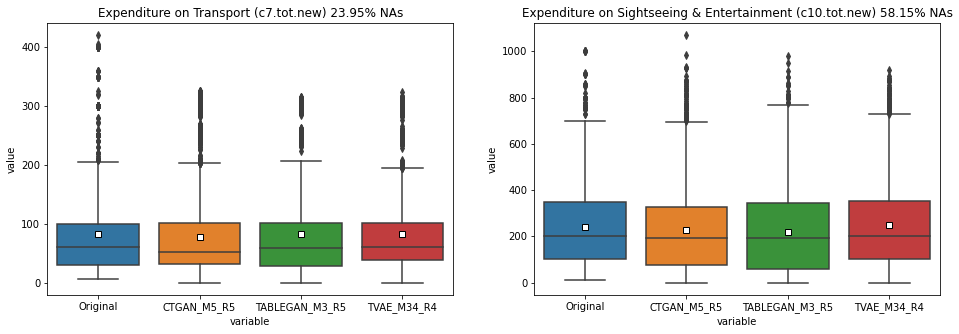

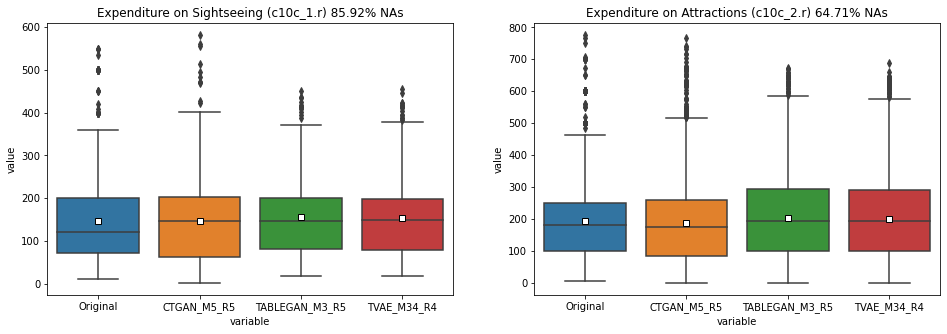

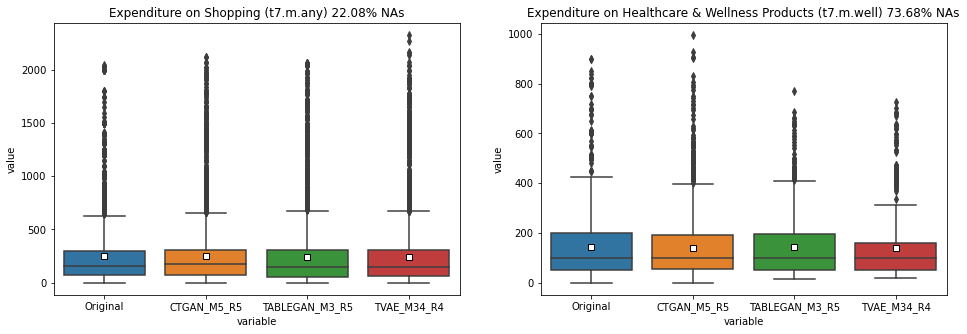

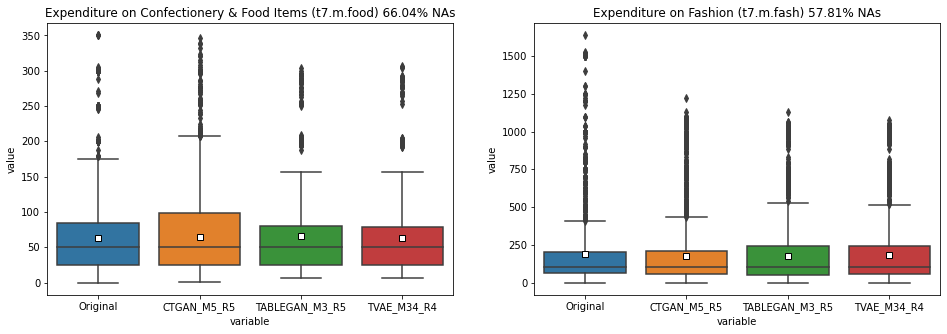

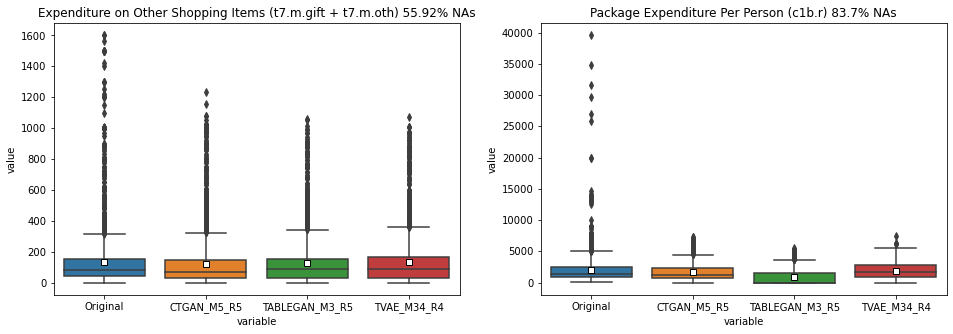

In [39]:
boxplots4(test_cleaned,samples_cleaned,list_expnd)

## 1.3 Bar charts for OVS1618_test data vs Synthetic data under three leading models (categorical benchmark variables)

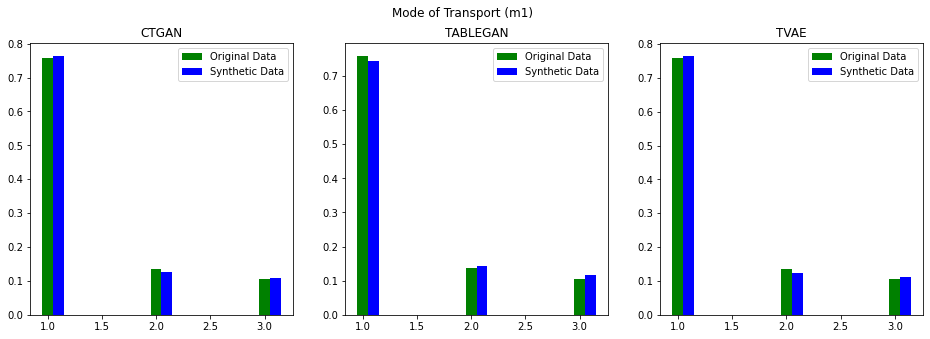

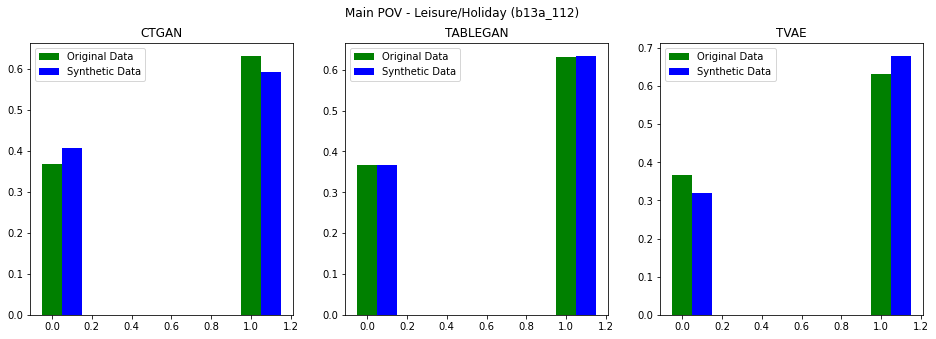

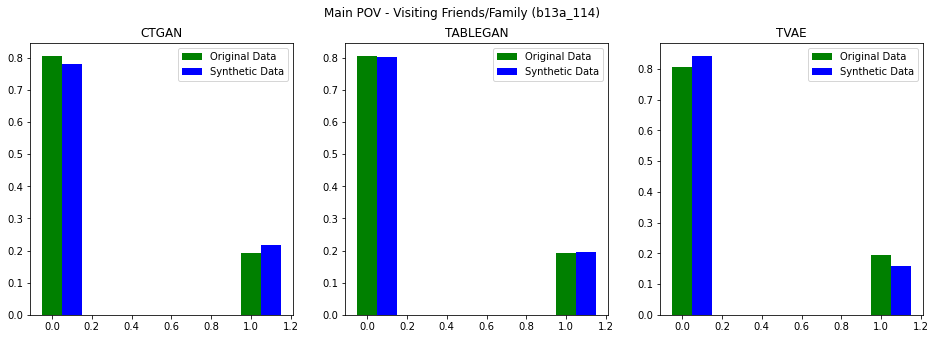

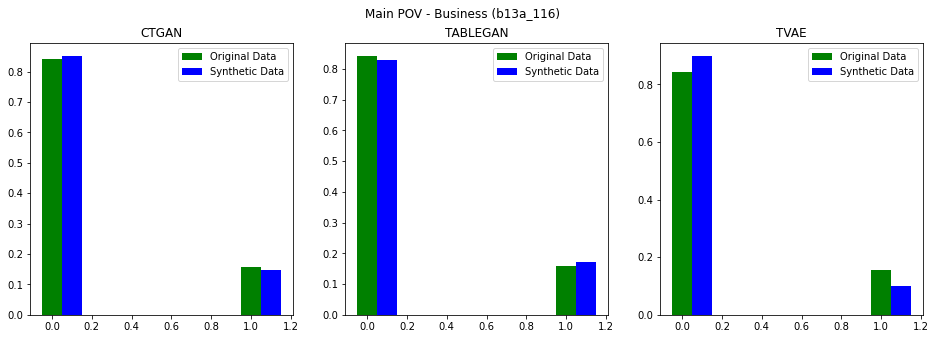

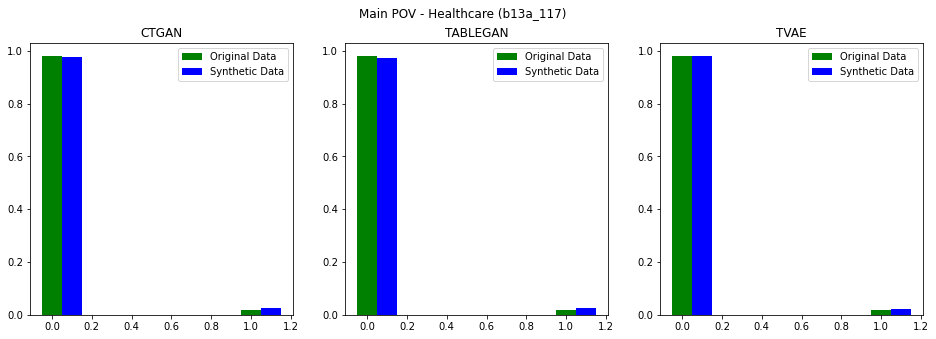

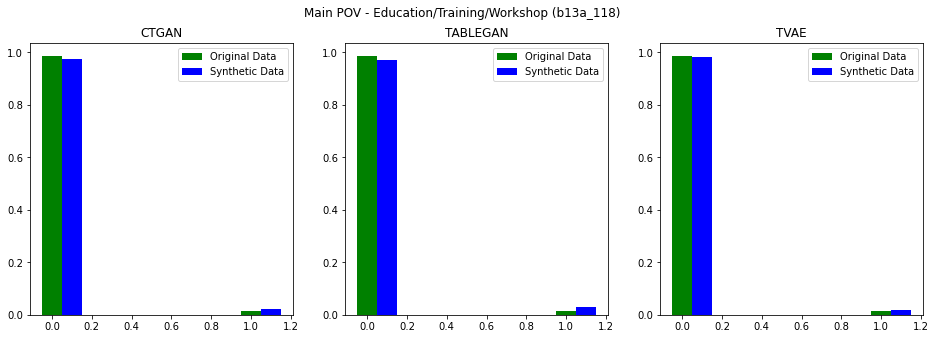

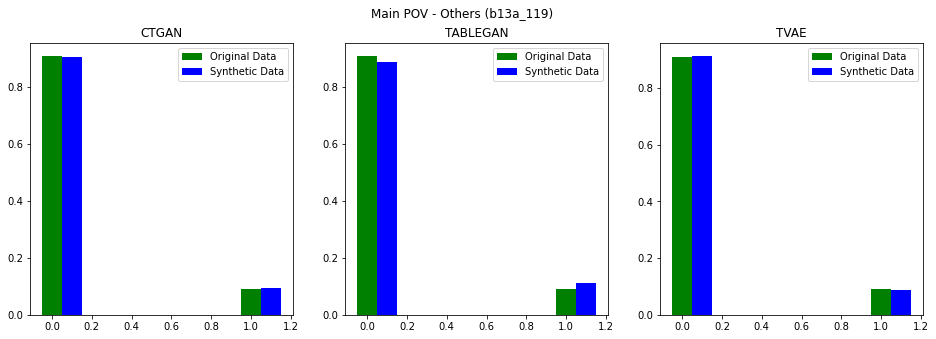

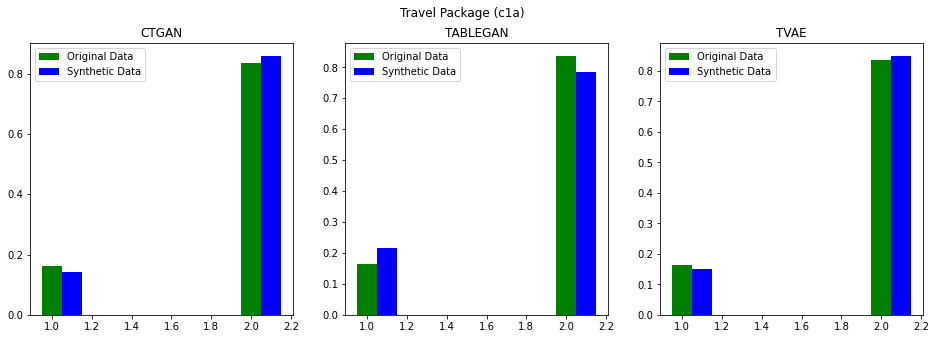

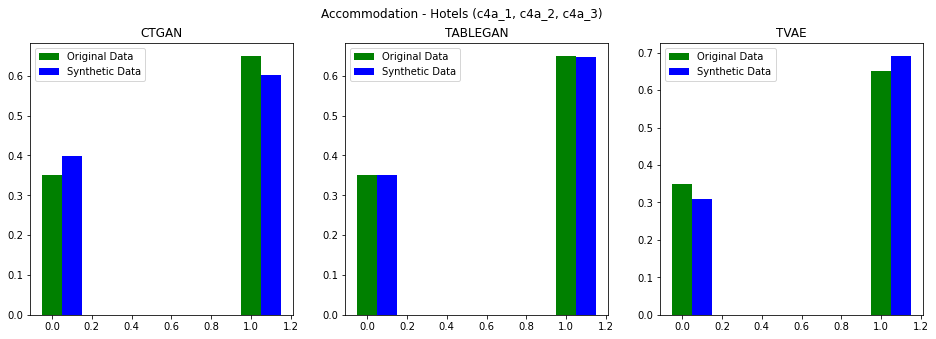

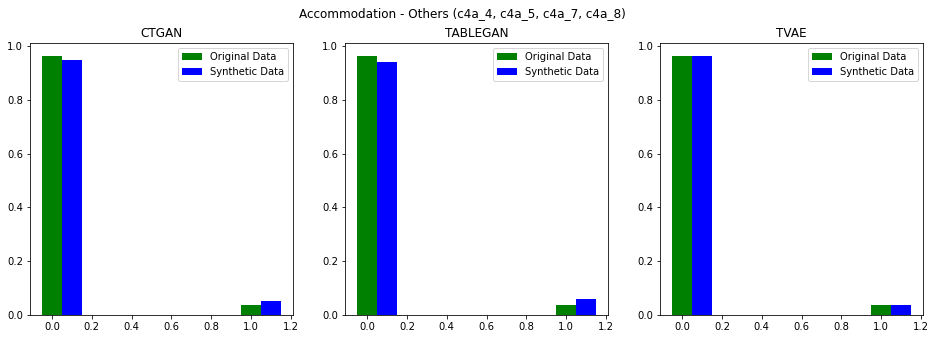

In [40]:
plots_bar(test_cleaned,samples_cleaned,list_cat)

# 2. Comparison Metrics

# 2.1 Absolute error between means/medians

In [41]:
def abs_diff_mean(real:pd.DataFrame,fake:pd.DataFrame,list_expnd=tuple()):
    result_list = []
    for col in list_expnd:
        result_list.append(abs(real[col]._get_numeric_data().mean()-fake[col]._get_numeric_data().mean()))
    return result_list

In [42]:
def abs_diff_median(real:pd.DataFrame,fake:pd.DataFrame,list_expnd=tuple()):
    result_list = []
    for col in list_expnd:
        result_list.append(abs(real[col]._get_numeric_data().median()-fake[col]._get_numeric_data().median()))
    return result_list

In [43]:
mean_diff = pd.DataFrame({'Variable':list_expnd})
median_diff = pd.DataFrame({'Variable':list_expnd})
for i in np.arange(len(samples_cleaned)):
    mean_diff[case[i]] = abs_diff_mean(test_cleaned,samples_cleaned[i],list_expnd)
    median_diff[case[i]] = abs_diff_median(test_cleaned,samples_cleaned[i],list_expnd)

In [44]:
## AE of mean
mean_diff

,Variable,CTGAN,TABLEGAN,TVAE
0,Expenditure on Accommodation (c4.tot.new),14.044259,83.311382,21.120759
1,Expenditure on F&B (c6.tot.new),16.149103,14.060675,6.603036
2,"Expenditure on Hawker Centre, Food Court or Co...",5.660861,3.418491,2.348392
3,Expenditure on Casual Dining (c6c_2.r),19.442778,12.597019,7.787104
4,Expenditure on Transport (c7.tot.new),4.126542,0.641506,0.165827
5,Expenditure on Sightseeing & Entertainment (c1...,15.453242,22.330619,6.753280
6,Expenditure on Sightseeing (c10c_1.r),1.231708,9.416369,7.736765
7,Expenditure on Attractions (c10c_2.r),4.820407,8.483119,7.037692
8,Expenditure on Shopping (t7.m.any),1.615318,13.354233,8.903834
9,Expenditure on Healthcare & Wellness Products ...,2.321969,1.697914,3.116377


In [45]:
count = np.zeros(len(case))
for i in range(mean_diff.shape[0]):
    for j in np.arange(len(case)):
        if sum(mean_diff.iloc[i][1:6]==np.min(mean_diff.iloc[i][1:6]))==1 and np.argmin(mean_diff.iloc[i][1:6]) == j:
            print("Winner is: " + str(j+1))
            count[j] +=1
for j in np.arange(len(case)):
    print("Number of winning cases for " + case[j] + ": ", count[j])

Winner is: 1
Winner is: 3
Winner is: 3
Winner is: 3
Winner is: 3
Winner is: 3
Winner is: 1
Winner is: 1
Winner is: 1
Winner is: 2
Winner is: 3
Winner is: 3
Winner is: 3
Winner is: 3
Number of winning cases for CTGAN:  4.0
Number of winning cases for TABLEGAN:  1.0
Number of winning cases for TVAE:  9.0


TVAE performs best in terms of AE of mean.

In [46]:
## AE of median
median_diff

,Variable,CTGAN,TABLEGAN,TVAE
0,Expenditure on Accommodation (c4.tot.new),7.788078,81.078455,11.009796
1,Expenditure on F&B (c6.tot.new),12.612333,11.828466,6.185896
2,"Expenditure on Hawker Centre, Food Court or Co...",3.336407,13.871321,2.626068
3,Expenditure on Casual Dining (c6c_2.r),31.062237,31.043520,0.835813
4,Expenditure on Transport (c7.tot.new),8.469093,0.852322,0.313556
5,Expenditure on Sightseeing & Entertainment (c1...,5.985661,6.132576,1.230178
6,Expenditure on Sightseeing (c10c_1.r),25.825997,26.010456,27.751480
7,Expenditure on Attractions (c10c_2.r),5.377844,14.594813,14.428810
8,Expenditure on Shopping (t7.m.any),19.159125,7.240783,10.565390
9,Expenditure on Healthcare & Wellness Products ...,0.713066,0.044119,0.009128


In [47]:
count = np.zeros(len(case))
for i in range(median_diff.shape[0]):
    for j in np.arange(len(case)):
        if sum(median_diff.iloc[i][1:6]==np.min(median_diff.iloc[i][1:6]))==1 and np.argmin(median_diff.iloc[i][1:6]) == j:
            print("Winner is: " + str(j+1))
            count[j] +=1
for j in np.arange(len(case)):
     print("Number of winning cases of " + case[j] +": ", count[j])

Winner is: 1
Winner is: 3
Winner is: 3
Winner is: 3
Winner is: 3
Winner is: 3
Winner is: 1
Winner is: 1
Winner is: 2
Winner is: 3
Winner is: 2
Winner is: 2
Winner is: 2
Winner is: 1
Number of winning cases of CTGAN:  4.0
Number of winning cases of TABLEGAN:  4.0
Number of winning cases of TVAE:  6.0


TVAE performs best in terms of AE of median

## 2.2 Coefficient of Variation

In [48]:
def COV(data:pd.DataFrame,list_expnd=tuple()):
    result_list = []
    for col in list_expnd:
        result_list.append(data[col]._get_numeric_data().std()/data[col]._get_numeric_data().mean())
    return result_list

In [49]:
COV_df = pd.DataFrame({'Variable':list_expnd,
                      'Real':COV(test_cleaned,list_expnd)})
for i in np.arange(len(samples_cleaned)):
    COV_df[case[i]] =  COV(samples_cleaned[i],list_expnd)

In [50]:
## Coefficient of Variation for real data and synthetic data under three models
COV_df

,Variable,Real,CTGAN,TABLEGAN,TVAE
0,Expenditure on Accommodation (c4.tot.new),0.863214,0.840034,0.959469,0.827965
1,Expenditure on F&B (c6.tot.new),0.863911,0.891768,0.940889,0.870262
2,"Expenditure on Hawker Centre, Food Court or Co...",0.861093,0.874288,0.855769,0.851720
3,Expenditure on Casual Dining (c6c_2.r),0.719760,0.786094,0.805671,0.738383
4,Expenditure on Transport (c7.tot.new),0.805852,0.799931,0.792064,0.775788
5,Expenditure on Sightseeing & Entertainment (c1...,0.723878,0.800291,0.848676,0.722162
6,Expenditure on Sightseeing (c10c_1.r),0.659977,0.627773,0.618618,0.592534
7,Expenditure on Attractions (c10c_2.r),0.672394,0.713221,0.704424,0.666309
8,Expenditure on Shopping (t7.m.any),1.072885,1.094878,1.185674,1.177840
9,Expenditure on Healthcare & Wellness Products ...,0.918355,0.913805,0.901558,0.895712


In [51]:
count = np.zeros(len(case))
for i in range(COV_df.shape[0]):
    for j in np.arange(len(case)):
        if np.argmin(abs(COV_df.iloc[i][case]-COV_df.iloc[i]['Real'])) == j:
            print("Winner is: " + str(j+1))
            count[j] +=1
for j in np.arange(len(case)):
     print("Number of winning cases of " + case[j] +": ", count[j])

Winner is: 1
Winner is: 3
Winner is: 2
Winner is: 3
Winner is: 1
Winner is: 3
Winner is: 1
Winner is: 3
Winner is: 1
Winner is: 1
Winner is: 3
Winner is: 2
Winner is: 1
Winner is: 2
Number of winning cases of CTGAN:  6.0
Number of winning cases of TABLEGAN:  3.0
Number of winning cases of TVAE:  5.0


CTGAN performs best in terms of Coefficient of Variation.

## 2.3 Number of Simular Columns based on Kullback-Leibler Divergence

In [52]:
def discrete_probs(column, unique_list):
    # find probability in the order of unique_list
    column = pd.Series(column)
    counts = column.value_counts()
    probs = []
    total_length = len(column)
    for i in unique_list:
        val = 0
        if i in counts.index:
            val = counts[i]
        probs.append(val/total_length)

    return np.array(probs)

# KL-divergence formula
def kl_divergence(p, q):
    p[p < 1e-12] = 1e-12
    q[q < 1e-12] = 1e-12
    a = np.log(p)
    b = np.log(q)
    return np.sum(p * (a - b))

###For continuous variables:
def ecdf(x):
    x = np.sort(x)
    u, c = np.unique(x, return_counts=True) 
    n = len(x)
    y = (np.cumsum(c) - 0.5)/n 
    def interpolate_(x_): 
        yinterp = np.interp(x_, u, y, left=0.0, right=1.0)
        return yinterp
    return interpolate_

def cumulative_continuous_kl(x,y,fraction=0.5):
    dx = np.diff(np.sort(np.unique(x))) 
    dy = np.diff(np.sort(np.unique(y)))
    ex = np.min(dx) 
    ey = np.min(dy)
    e = np.min([ex,ey])*fraction 
    n = len(x)
    P = ecdf(x)
    Q = ecdf(y)
    p = P(x) - P(x-e)
    q = Q(x) - Q(x-e)
    p[p < 1e-12] = 1e-12
    q[q < 1e-12] = 1e-12
    KL = abs((1./n)*np.sum(np.log(p/q))-1) 
    return KL

In [53]:
def KLD(real, fake, discrete_columns):
    KLD = []
    for column in fake.columns:
        column_fake = fake[column].values
        column_real = real[column].values
        if column in discrete_columns:
            # find list of all unique values
            column_real = column_real[~np.isnan(column_real)]
            column_fake = column_fake[~np.isnan(column_fake)]
            unique_list = []
            arrs = [np.unique(column_fake), np.unique(column_real)]
            for arr in arrs:
                for val in arr:
                    if val not in unique_list:
                        unique_list.append(val)
            # find probabilities of values according to order in unique_list
            fake_prob = discrete_probs(column_fake, unique_list)
            real_prob = discrete_probs(column_real, unique_list)
            KLD.append((kl_divergence(fake_prob, real_prob)+kl_divergence(real_prob,fake_prob)/2))
        else:
            # check whether indicator columns exist
            if column + '_cat' in fake.columns:
                column_fake = column_fake[fake[column + '_cat'] == 0]
                column_real = column_real[real[column + '_cat'] == 0]
                ## list all continuous variables for which 0 is meaningful
                column_list = ['b10','b11','b12number_1','b12number_2','b12number_3_5',
                               'b12number_4','b12number_6','b12number_7_8','c1c','c4c_1','b12b_1','b12b_2']
                if column in column_list:
                    column_fake = column_fake[column_fake >= 0]
                    column_real = column_real[column_real >= 0]
                else:
                    column_fake = column_fake[column_fake > 0]
                    column_real = column_real[column_real > 0]
                if len(column_fake) >= 1000 and len(column_real) >= 1000:
                    KLD.append((cumulative_continuous_kl(column_fake, column_real)+cumulative_continuous_kl(column_real, column_fake))/2)
                else:
                    KLD.append(np.nan)
            else:
                KLD.append((cumulative_continuous_kl(column_fake, column_real)+cumulative_continuous_kl(column_real, column_fake))/2)
    return np.array(KLD)

In [54]:
kld = pd.DataFrame({'Variable':test_cleaned.columns})
for i in np.arange(len(samples_cleaned)):
    kld[case[i]] = np.round_(KLD(test_cleaned, samples_cleaned[i], discrete_cols),4)

In [55]:
kld_benchmark = kld[kld['Variable'].isin(list_expnd+list_cat)]

In [56]:
count = np.zeros(len(case))
for i in range(kld_benchmark[case].shape[0]):
    for j in np.arange(len(case)):
        if sum(kld_benchmark[case].iloc[i]==np.min(kld_benchmark[case].iloc[i]))==1 and  np.argmin(kld_benchmark[case].iloc[i]) == j:
            count[j] +=1
for j in np.arange(len(case)):
    print("Number of similar columns by using " + case[j] +": ", count[j])

Number of similar columns by using CTGAN:  11.0
Number of similar columns by using TABLEGAN:  5.0
Number of similar columns by using TVAE:  7.0


CTGAN performs best in terms of number of similar columns based on KLD.

## 2.4 Overlapping 95% Confidence Intervals

In [57]:
# Compute statistics for continuous benchmarks
def continuous_statistics(df, list_cols):
    result_df = df[list_cols].describe()
    result_df = result_df.transpose()
    result_df['count'] = result_df['count'].astype(int)
        
    # Compute the standard error of the mean
    result_df.insert(loc = 2, column = 'Standard Error', value = df[list_cols].sem())
    
    # Compute 95% Confidence Interval (assuming normal distribution)
    result_df.loc[:,'Lower 95% CI'], result_df.loc[:,'Upper 95% CI'] = stats.norm.interval(0.95, loc=result_df.loc[:,'mean'], scale=result_df.loc[:,'Standard Error'])
    
    result_df.rename(columns = {'count': 'Count', 'mean': 'Mean', 'std': 'Standard Deviation', '50%': 'Median'}, inplace=True)
    return result_df

In [58]:
# Compute statistics for categorical benchmarks
def categorical_statistics(df, list_cols):
    result_df = df[list_cols].melt(var_name='Variable', value_name='Value').groupby(['Variable', 'Value']).size().to_frame(name='Count')
    result_df['Proportion'] = result_df['Count'].div(result_df['Count'].sum(level=0), level=0)
    result_df['np>5'] = (result_df['Count'] * result_df['Proportion']) > 5
    result_df['nq>5'] = (result_df['Count'] * (1 - result_df['Proportion'])) > 5
    result_df['Standard Error'] = np.sqrt(result_df['Proportion'] * (1-result_df['Proportion']) / result_df['Count'].sum(level=0))
    result_df['Lower 95% CI'] = result_df['Proportion'] - 1.96 * result_df['Standard Error']
    result_df['Upper 95% CI'] = result_df['Proportion'] + 1.96 * result_df['Standard Error']
    return result_df

In [59]:
cat_stat = []
con_stat = []

for i in np.arange(len(samples_cleaned)):
    cat_stat.append(categorical_statistics(samples_cleaned[i],list_cat))
    con_stat.append(continuous_statistics(samples_cleaned[i],list_expnd))

In [60]:
## count/proportion/standard error/95% CI for categorical variables of synthetic data given by CTGAN
cat_stat[0]

Count  Proportion  \
Variable                                           Value                      
Accommodation - Hotels (c4a_1, c4a_2, c4a_3)       0       3952    0.398990   
                                                   1       5953    0.601010   
Accommodation - Others (c4a_4, c4a_5, c4a_7, c4... 0       9392    0.948208   
                                                   1        513    0.051792   
Main POV - Business (b13a_116)                     0       8437    0.851792   
                                                   1       1468    0.148208   
Main POV - Education/Training/Workshop (b13a_118)  0       9672    0.976477   
                                                   1        233    0.023523   
Main POV - Healthcare (b13a_117)                   0       9668    0.976073   
                                                   1        237    0.023927   
Main POV - Leisure/Holiday (b13a_112)              0       4038    0.407673   
                                                   1       5867    0.592327   
Main POV - Others (b13a_119)                       0       8977    0.906310   
                                                   1        928    0.093690   
Main POV - Visiting Friends/Family (b13a_114)      0       7744    0.781827   
                                                   1       2161    0.218173   
Mode of Transport (m1)                             1       7565    0.763756   
                                                   2       1262    0.127410   
                                                   3       1078    0.108834   
Travel Package (c1a)                               1       1396    0.140939   
                                                   2       8509    0.859061   

                                                          np>5  nq>5  \
Variable                                           Value               
Accommodation - Hotels (c4a_1, c4a_2, c4a_3)       0      True  True   
                                                   1      True  True   
Accommodation - Others (c4a_4, c4a_5, c4a_7, c4... 0      True  True   
                                                   1      True  True   
Main POV - Business (b13a_116)                     0      True  True   
                                                   1      True  True   
Main POV - Education/Training/Workshop (b13a_118)  0      True  True   
                                                   1      True  True   
Main POV - Healthcare (b13a_117)                   0      True  True   
                                                   1      True  True   
Main POV - Leisure/Holiday (b13a_112)              0      True  True   
                                                   1      True  True   
Main POV - Others (b13a_119)                       0      True  True   
                                                   1      True  True   
Main POV - Visiting Friends/Family (b13a_114)      0      True  True   
                                                   1      True  True   
Mode of Transport (m1)                             1      True  True   
                                                   2      True  True   
                                                   3      True  True   
Travel Package (c1a)                               1      True  True   
                                                   2      True  True   

                                                          Standard Error  \
Variable                                           Value                   
Accommodation - Hotels (c4a_1, c4a_2, c4a_3)       0            0.004920   
                                                   1            0.004920   
Accommodation - Others (c4a_4, c4a_5, c4a_7, c4... 0            0.002227   
                                                   1            0.002227   
Main POV - Business (b13a_116)                     0            0.003570   
                                                   

In [61]:
## count/proportion/standard error/95% CI for categorical variables of synthetic data given by TableGAN
cat_stat[1]

Count  Proportion  \
Variable                                           Value                      
Accommodation - Hotels (c4a_1, c4a_2, c4a_3)       0       3481    0.351439   
                                                   1       6424    0.648561   
Accommodation - Others (c4a_4, c4a_5, c4a_7, c4... 0       9312    0.940131   
                                                   1        593    0.059869   
Main POV - Business (b13a_116)                     0       8201    0.827966   
                                                   1       1704    0.172034   
Main POV - Education/Training/Workshop (b13a_118)  0       9611    0.970318   
                                                   1        294    0.029682   
Main POV - Healthcare (b13a_117)                   0       9648    0.974054   
                                                   1        257    0.025946   
Main POV - Leisure/Holiday (b13a_112)              0       3625    0.365977   
                                                   1       6280    0.634023   
Main POV - Others (b13a_119)                       0       8799    0.888339   
                                                   1       1106    0.111661   
Main POV - Visiting Friends/Family (b13a_114)      0       7964    0.804038   
                                                   1       1941    0.195962   
Mode of Transport (m1)                             1       7354    0.742453   
                                                   2       1408    0.142150   
                                                   3       1143    0.115396   
Travel Package (c1a)                               1       2145    0.216557   
                                                   2       7760    0.783443   

                                                          np>5  nq>5  \
Variable                                           Value               
Accommodation - Hotels (c4a_1, c4a_2, c4a_3)       0      True  True   
                                                   1      True  True   
Accommodation - Others (c4a_4, c4a_5, c4a_7, c4... 0      True  True   
                                                   1      True  True   
Main POV - Business (b13a_116)                     0      True  True   
                                                   1      True  True   
Main POV - Education/Training/Workshop (b13a_118)  0      True  True   
                                                   1      True  True   
Main POV - Healthcare (b13a_117)                   0      True  True   
                                                   1      True  True   
Main POV - Leisure/Holiday (b13a_112)              0      True  True   
                                                   1      True  True   
Main POV - Others (b13a_119)                       0      True  True   
                                                   1      True  True   
Main POV - Visiting Friends/Family (b13a_114)      0      True  True   
                                                   1      True  True   
Mode of Transport (m1)                             1      True  True   
                                                   2      True  True   
                                                   3      True  True   
Travel Package (c1a)                               1      True  True   
                                                   2      True  True   

                                                          Standard Error  \
Variable                                           Value                   
Accommodation - Hotels (c4a_1, c4a_2, c4a_3)       0            0.004797   
                                                   1            0.004797   
Accommodation - Others (c4a_4, c4a_5, c4a_7, c4... 0            0.002384   
                                                   1            0.002384   
Main POV - Business (b13a_116)                     0            0.003792   
                                                   

In [62]:
## count/proportion/standard error/95% CI for categorical variables of synthetic data given by TVAE
cat_stat[2]

Count  Proportion  \
Variable                                           Value                      
Accommodation - Hotels (c4a_1, c4a_2, c4a_3)       0       3058    0.308733   
                                                   1       6847    0.691267   
Accommodation - Others (c4a_4, c4a_5, c4a_7, c4... 0       9534    0.962544   
                                                   1        371    0.037456   
Main POV - Business (b13a_116)                     0       8905    0.899041   
                                                   1       1000    0.100959   
Main POV - Education/Training/Workshop (b13a_118)  0       9734    0.982736   
                                                   1        171    0.017264   
Main POV - Healthcare (b13a_117)                   0       9697    0.979001   
                                                   1        208    0.020999   
Main POV - Leisure/Holiday (b13a_112)              0       3178    0.320848   
                                                   1       6727    0.679152   
Main POV - Others (b13a_119)                       0       9052    0.913882   
                                                   1        853    0.086118   
Main POV - Visiting Friends/Family (b13a_114)      0       8346    0.842605   
                                                   1       1559    0.157395   
Mode of Transport (m1)                             1       7576    0.764866   
                                                   2       1211    0.122261   
                                                   3       1118    0.112872   
Travel Package (c1a)                               1       1496    0.151035   
                                                   2       8409    0.848965   

                                                           np>5  nq>5  \
Variable                                           Value                
Accommodation - Hotels (c4a_1, c4a_2, c4a_3)       0       True  True   
                                                   1       True  True   
Accommodation - Others (c4a_4, c4a_5, c4a_7, c4... 0       True  True   
                                                   1       True  True   
Main POV - Business (b13a_116)                     0       True  True   
                                                   1       True  True   
Main POV - Education/Training/Workshop (b13a_118)  0       True  True   
                                                   1      False  True   
Main POV - Healthcare (b13a_117)                   0       True  True   
                                                   1      False  True   
Main POV - Leisure/Holiday (b13a_112)              0       True  True   
                                                   1       True  True   
Main POV - Others (b13a_119)                       0       True  True   
                                                   1       True  True   
Main POV - Visiting Friends/Family (b13a_114)      0       True  True   
                                                   1       True  True   
Mode of Transport (m1)                             1       True  True   
                                                   2       True  True   
                                                   3       True  True   
Travel Package (c1a)                               1       True  True   
                                                   2       True  True   

                                                          Standard Error  \
Variable                                           Value                   
Accommodation - Hotels (c4a_1, c4a_2, c4a_3)       0            0.004642   
                                                   1            0.004642   
Accommodation - Others (c4a_4, c4a_5, c4a_7, c4... 0            0.001908   
                                                   1            0.001908   
Main POV - Business (b13a_116)                     0            0.003027   
                            

In [63]:
real_cat_stat = categorical_statistics(test_cleaned,list_cat)

In [64]:
## count/proportion/standard error/95% CI for categorical variables of real data
real_cat_stat

Count  Proportion  \
Variable                                           Value                      
Accommodation - Hotels (c4a_1, c4a_2, c4a_3)       0       3467    0.350025   
                                                   1       6438    0.649975   
Accommodation - Others (c4a_4, c4a_5, c4a_7, c4... 0       9540    0.963150   
                                                   1        365    0.036850   
Main POV - Business (b13a_116)                     0       8347    0.842706   
                                                   1       1558    0.157294   
Main POV - Education/Training/Workshop (b13a_118)  0       9769    0.986270   
                                                   1        136    0.013730   
Main POV - Healthcare (b13a_117)                   0       9709    0.980212   
                                                   1        196    0.019788   
Main POV - Leisure/Holiday (b13a_112)              0       3639    0.367390   
                                                   1       6266    0.632610   
Main POV - Others (b13a_119)                       0       9012    0.909844   
                                                   1        893    0.090156   
Main POV - Visiting Friends/Family (b13a_114)      0       7984    0.806058   
                                                   1       1921    0.193942   
Mode of Transport (m1)                             1       7515    0.758708   
                                                   2       1351    0.136396   
                                                   3       1039    0.104897   
Travel Package (c1a)                               1       1615    0.163049   
                                                   2       8290    0.836951   

                                                           np>5  nq>5  \
Variable                                           Value                
Accommodation - Hotels (c4a_1, c4a_2, c4a_3)       0       True  True   
                                                   1       True  True   
Accommodation - Others (c4a_4, c4a_5, c4a_7, c4... 0       True  True   
                                                   1       True  True   
Main POV - Business (b13a_116)                     0       True  True   
                                                   1       True  True   
Main POV - Education/Training/Workshop (b13a_118)  0       True  True   
                                                   1      False  True   
Main POV - Healthcare (b13a_117)                   0       True  True   
                                                   1      False  True   
Main POV - Leisure/Holiday (b13a_112)              0       True  True   
                                                   1       True  True   
Main POV - Others (b13a_119)                       0       True  True   
                                                   1       True  True   
Main POV - Visiting Friends/Family (b13a_114)      0       True  True   
                                                   1       True  True   
Mode of Transport (m1)                             1       True  True   
                                                   2       True  True   
                                                   3       True  True   
Travel Package (c1a)                               1       True  True   
                                                   2       True  True   

                                                          Standard Error  \
Variable                                           Value                   
Accommodation - Hotels (c4a_1, c4a_2, c4a_3)       0            0.004793   
                                                   1            0.004793   
Accommodation - Others (c4a_4, c4a_5, c4a_7, c4... 0            0.001893   
                                                   1            0.001893   
Main POV - Business (b13a_116)                     0            0.003658   
                            

In [65]:
real_con_stat = continuous_statistics(test_cleaned,list_expnd)

In [66]:
# count/mean/standard deviation/median/95% CI for continuous variable of real data
real_con_stat

,Count,Mean,Standard Error,Standard Deviation,min,25%,Median,75%,max,Lower 95% CI,Upper 95% CI
Expenditure on Accommodation (c4.tot.new),6828,622.123303,6.499028,537.025828,10.00,280.0000,500.00,800.0,7000.00,609.385442,634.861164
Expenditure on F&B (c6.tot.new),7933,245.916651,2.385273,212.450028,8.00,82.6600,200.00,350.0,1400.00,241.241602,250.591700
"Expenditure on Hawker Centre, Food Court or Coffee Shop (c6c_1.r)",5569,109.789727,1.266844,94.539154,4.00,50.0000,85.00,150.0,520.50,107.306759,112.272695
Expenditure on Casual Dining (c6c_2.r),5437,213.442928,2.083482,153.627686,0.01,100.0000,200.00,300.0,900.00,209.359378,217.526478
Expenditure on Transport (c7.tot.new),7533,82.374022,0.764824,66.381302,6.00,30.0000,60.00,100.0,420.00,80.874994,83.873051
Expenditure on Sightseeing & Entertainment (c10.tot.new),4145,241.504550,2.715365,174.819765,12.00,100.0000,200.00,350.0,1000.00,236.182532,246.826568
Expenditure on Sightseeing (c10c_1.r),1395,145.510373,2.571197,96.033450,10.00,71.8200,121.76,200.0,550.00,140.470918,150.549827
Expenditure on Attractions (c10c_2.r),3495,192.790272,2.192732,129.631062,4.00,100.0000,180.00,250.0,775.02,188.492597,197.087947
Expenditure on Shopping (t7.m.any),7718,252.637714,3.085311,271.051175,0.09,75.0000,155.94,300.0,2046.72,246.590617,258.684812
Expenditure on Healthcare & Wellness Products (t7.m.well),2607,141.305086,2.541544,129.768168,0.12,50.0000,100.00,200.0,900.00,136.323751,146.286421


In [67]:
# count/mean/standard deviation/median/95% CI for continuous variable of synthetic data given by CTGAN
con_stat[0]

,Count,Mean,Standard Error,Standard Deviation,min,25%,Median,75%,max,Lower 95% CI,Upper 95% CI
Expenditure on Accommodation (c4.tot.new),6181,608.079043,6.497218,510.806965,0.089460,241.363498,492.211922,815.383739,4197.206430,595.344730,620.813357
Expenditure on F&B (c6.tot.new),7428,229.767548,2.377412,204.899238,0.001136,82.168871,187.387667,315.274445,1383.105566,225.107907,234.427189
"Expenditure on Hawker Centre, Food Court or Coffee Shop (c6c_1.r)",4721,104.128866,1.324978,91.038640,0.000608,44.308550,81.663593,149.081005,559.365444,101.531956,106.725775
Expenditure on Casual Dining (c6c_2.r),4561,194.000150,2.258116,152.502289,0.015822,92.901501,168.937763,294.346913,845.934499,189.574323,198.425977
Expenditure on Transport (c7.tot.new),7267,78.247480,0.734252,62.592573,0.004043,31.881340,51.530907,100.607746,326.094991,76.808373,79.686588
Expenditure on Sightseeing & Entertainment (c10.tot.new),3574,226.051308,3.026060,180.906789,0.009374,77.228038,194.014339,325.649470,1068.930641,220.120338,231.982277
Expenditure on Sightseeing (c10c_1.r),857,146.742080,3.146782,92.120680,2.550524,63.503929,147.585997,201.859973,581.080645,140.574500,152.909661
Expenditure on Attractions (c10c_2.r),2800,187.969865,2.533573,134.064081,0.005938,83.604450,174.622156,257.612096,766.732896,183.004153,192.935577
Expenditure on Shopping (t7.m.any),7475,251.022397,3.178869,274.838918,0.003970,67.203058,175.099125,303.518966,2119.093670,244.791928,257.252865
Expenditure on Healthcare & Wellness Products (t7.m.well),1849,138.983117,2.953568,127.003417,0.003812,53.255701,100.713066,190.517381,994.076482,133.194230,144.772004


In [68]:
# count/mean/standard deviation/median/95% CI for continuous variable of synthetic data given by TableGAN
con_stat[1]

,Count,Mean,Standard Error,Standard Deviation,min,25%,Median,75%,max,Lower 95% CI,Upper 95% CI
Expenditure on Accommodation (c4.tot.new),5815,538.811920,6.779430,516.973229,0.009281,151.255315,418.921545,757.585534,3569.731480,525.524481,552.099359
Expenditure on F&B (c6.tot.new),6565,231.855976,2.692400,218.150838,0.000846,55.202776,188.171534,354.052548,1296.292501,226.578969,237.132982
"Expenditure on Hawker Centre, Food Court or Coffee Shop (c6c_1.r)",3037,113.208218,1.757973,96.880088,0.047703,47.169662,98.871321,152.119960,535.815048,109.762655,116.653781
Expenditure on Casual Dining (c6c_2.r),2958,200.845909,2.975237,161.815707,0.003005,70.108485,168.956480,297.741339,851.430552,195.014552,206.677267
Expenditure on Transport (c7.tot.new),5270,81.732516,0.891764,64.737391,0.010499,28.826931,59.147678,100.703966,315.900564,79.984691,83.480341
Expenditure on Sightseeing & Entertainment (c10.tot.new),2047,219.173931,4.111232,186.007713,0.005822,58.081387,193.867424,342.509520,978.992967,211.116063,227.231798
Expenditure on Sightseeing (c10c_1.r),268,154.926742,5.854385,95.840410,18.408114,81.864061,147.770456,199.512030,449.947788,143.452358,166.401125
Expenditure on Attractions (c10c_2.r),1223,201.273391,4.054218,141.781760,0.012208,99.854597,194.594813,294.075669,672.396793,193.327269,209.219513
Expenditure on Shopping (t7.m.any),6609,239.283482,3.489878,283.712250,0.015153,49.478812,148.699217,302.811968,2063.422420,232.443447,246.123516
Expenditure on Healthcare & Wellness Products (t7.m.well),817,143.003001,4.510534,128.925546,14.347997,50.861195,99.955881,195.526715,770.107283,134.162517,151.843485


In [69]:
# count/mean/standard deviation/median/95% CI for continuous variable of synthetic data given by TVAE
con_stat[2]

,Count,Mean,Standard Error,Standard Deviation,min,25%,Median,75%,max,Lower 95% CI,Upper 95% CI
Expenditure on Accommodation (c4.tot.new),7119,601.002544,5.897648,497.609111,0.001642,252.798111,488.990204,787.040196,4020.696016,589.443367,612.561721
Expenditure on F&B (c6.tot.new),7474,239.313615,2.409021,208.265428,0.002282,87.313690,193.814104,349.990300,1294.376011,234.592020,244.035210
"Expenditure on Hawker Centre, Food Court or Coffee Shop (c6c_1.r)",3740,112.138119,1.561760,95.510266,0.000213,47.056511,87.626068,151.808769,529.074511,109.077126,115.199112
Expenditure on Casual Dining (c6c_2.r),3665,221.230032,2.698289,163.352387,0.000951,100.296663,199.164187,300.210773,851.162621,215.941483,226.518582
Expenditure on Transport (c7.tot.new),6493,82.208196,0.791472,63.776141,0.015277,38.086529,59.686444,100.590436,324.156824,80.656939,83.759452
Expenditure on Sightseeing & Entertainment (c10.tot.new),3282,248.257830,3.129452,179.282383,0.001244,101.908753,201.230178,353.229517,920.587750,242.124216,254.391443
Expenditure on Sightseeing (c10c_1.r),447,153.247138,4.294886,90.804090,18.374130,78.379468,149.511480,198.661404,456.646919,144.829316,161.664960
Expenditure on Attractions (c10c_2.r),2470,199.827964,2.679065,133.147123,0.026977,99.879435,194.428810,291.616071,687.385695,194.577092,205.078835
Expenditure on Shopping (t7.m.any),7962,243.733881,3.217297,287.079559,0.011207,57.249975,145.374610,302.124200,2325.053562,237.428094,250.039667
Expenditure on Healthcare & Wellness Products (t7.m.well),907,138.188709,4.109959,123.777338,16.716194,51.372604,99.990872,157.203924,727.330268,130.133337,146.244081


In [70]:
cmap = plt.get_cmap("tab10")

In [71]:
import copy
def plot_CI(real: pd.DataFrame, fake: list, cases=tuple(), cont=True):
    num_list = len(fake)
    col =  plt.get_cmap("tab10")

    if cont:
        for i in np.arange(real.shape[0])[::2]:
            fig,ax = plt.subplots(1, 2, figsize=(12, 1))
            for k in np.arange(2): 
                    ax[k].set_ylim([0.9,1.7])
                    ax[k].set_title(real.index[i+k],fontsize=10)
                    ax[k].errorbar(x=real['Mean'].values[i+k], y=1, xerr=1.96*real['Standard Error'].values[i+k],fmt='D', color='g',label='Real Data')
                    ax[k].axvline(x=real['Lower 95% CI'].values[i+k],linestyle='--',color='red')
                    ax[k].axvline(x=real['Upper 95% CI'].values[i+k],linestyle='--',color='red')
                    for j in np.arange(num_list):
                        ax[k].errorbar(x=fake[j]['Mean'].values[i+k],y=1+0.1*(j+1), xerr=1.96*fake[j]['Standard Error'].values[i+k], fmt='o',color=col(j),alpha=.3, label=cases[j])
        handles, labels = ax[1].get_legend_handles_labels()
        ax[1].legend(handles,labels,bbox_to_anchor=(1.05, 1.02, 1., .102), handlelength=2, loc='upper right',ncol=1, mode="expand", borderaxespad=0.)

    else:
        for i in np.arange(real.shape[0])[::3]:
            fig,ax = plt.subplots(1, 3, figsize=(14, 1))
            for k in np.arange(3):   
                    ax[k].set_ylim([0.9,1.7])
                    ax[k].set_title(real.index[i+k],fontsize=8)
                    ax[k].errorbar(x=real['Proportion'].values[i+k], y=1, xerr=1.96*real['Standard Error'].values[i+k],fmt='D', color='g',label='Real Data')
                    ax[k].axvline(x=real['Lower 95% CI'].values[i+k],linestyle='--',color='red')
                    ax[k].axvline(x=real['Upper 95% CI'].values[i+k],linestyle='--',color='red')
                    for j in np.arange(num_list):
                        ax[k].errorbar(x=fake[j]['Proportion'].values[i+k],y=1+0.1*(j+1), xerr=1.96*fake[j]['Standard Error'].values[i+k], fmt='o',color=col(j),alpha=.3, label=cases[j])
        
        lines, labels = ax[2].get_legend_handles_labels()
        ax[2].legend(lines,labels,bbox_to_anchor=(1.05, 1.02, 1., .102),handlelength=4,loc='upper right',ncol=1, mode="expand", borderaxespad=0.)

   # fig.legend(lines, labels,ncol=1,bbox_to_anchor =(1, 1),loc='upper right',bbox_transform=plt.gcf().transFigure,borderaxespad=0.)           
    plt.show()

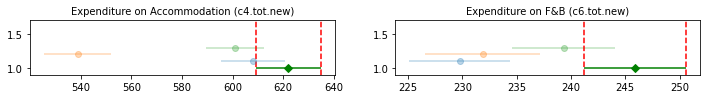

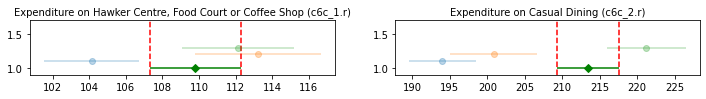

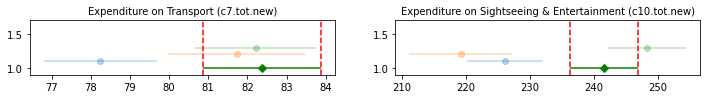

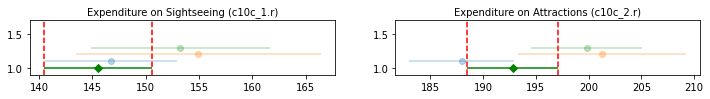

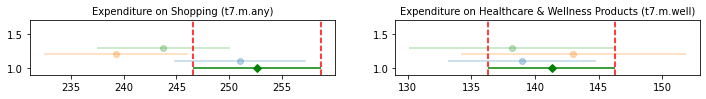

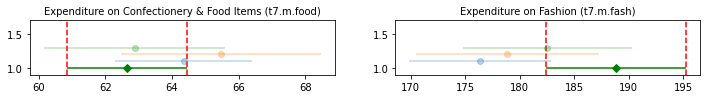

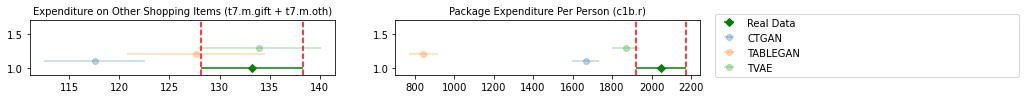

In [72]:
# Continuous variables
plot_CI(real_con_stat,fake = con_stat,cases=case,cont=True)

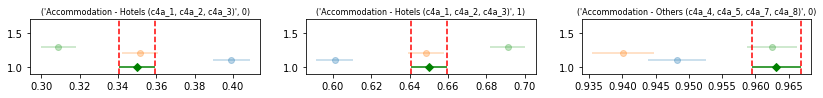

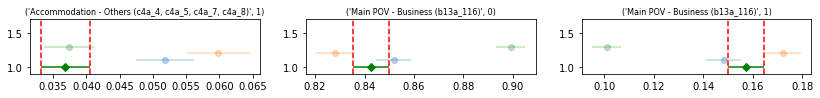

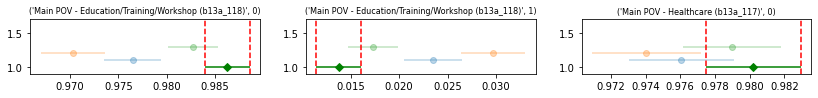

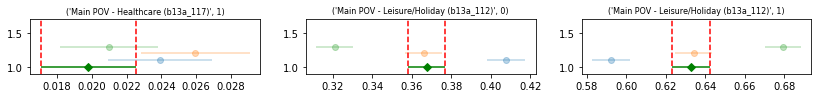

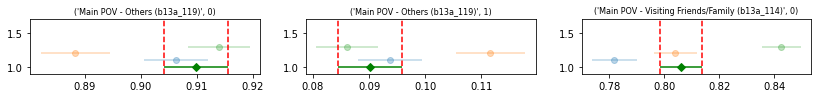

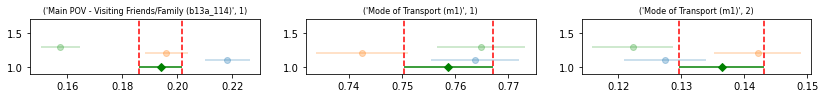

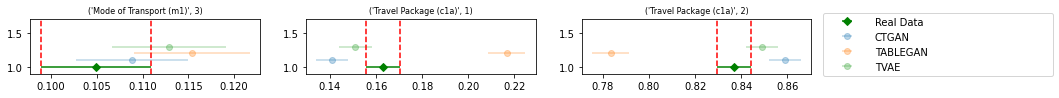

In [73]:
# categorical variables
plot_CI(real_cat_stat,fake = cat_stat,cases=case,cont=False)

In [74]:
def check_overlap(real,  fake):
    count = 0
    for i in np.arange(real.shape[0]):
        if real.iloc[i]['Upper 95% CI']<fake.iloc[i]['Lower 95% CI'] or real.iloc[i]['Lower 95% CI']>fake.iloc[i]['Upper 95% CI']:
            print( "Row" + str(i) + ": No")
        else:
            print("Row" + str(i)+": Yes")
            count +=1
    return count

In [75]:
for i in np.arange(len(samples_cleaned)):
    print(case[i])
    num_overlap = check_overlap(real_con_stat,con_stat[i])
    print("Number of Yes:" + str(num_overlap))

CTGAN
Row0: Yes
Row1: No
Row2: No
Row3: No
Row4: No
Row5: No
Row6: Yes
Row7: Yes
Row8: Yes
Row9: Yes
Row10: Yes
Row11: Yes
Row12: No
Row13: No
Number of Yes:7
TABLEGAN
Row0: No
Row1: No
Row2: Yes
Row3: No
Row4: Yes
Row5: No
Row6: Yes
Row7: Yes
Row8: No
Row9: Yes
Row10: Yes
Row11: Yes
Row12: Yes
Row13: No
Number of Yes:8
TVAE
Row0: Yes
Row1: Yes
Row2: Yes
Row3: Yes
Row4: Yes
Row5: Yes
Row6: Yes
Row7: Yes
Row8: Yes
Row9: Yes
Row10: Yes
Row11: Yes
Row12: Yes
Row13: Yes
Number of Yes:14


TVAE perform best in terms of 95% CI for continuous variables 

In [76]:
for i in np.arange(len(samples_cleaned)):
    print(case[i])
    num_overlap = check_overlap(real_cat_stat,cat_stat[i])
    print("Number of Yes:" + str(num_overlap))

CTGAN
Row0: No
Row1: No
Row2: No
Row3: No
Row4: Yes
Row5: Yes
Row6: No
Row7: No
Row8: Yes
Row9: Yes
Row10: No
Row11: No
Row12: Yes
Row13: Yes
Row14: No
Row15: No
Row16: Yes
Row17: Yes
Row18: Yes
Row19: No
Row20: No
Number of Yes:9
TABLEGAN
Row0: Yes
Row1: Yes
Row2: No
Row3: No
Row4: No
Row5: No
Row6: No
Row7: No
Row8: No
Row9: No
Row10: Yes
Row11: Yes
Row12: No
Row13: No
Row14: Yes
Row15: Yes
Row16: Yes
Row17: Yes
Row18: Yes
Row19: No
Row20: No
Number of Yes:9
TVAE
Row0: No
Row1: No
Row2: Yes
Row3: Yes
Row4: No
Row5: No
Row6: Yes
Row7: Yes
Row8: Yes
Row9: Yes
Row10: No
Row11: No
Row12: Yes
Row13: Yes
Row14: No
Row15: No
Row16: Yes
Row17: No
Row18: Yes
Row19: Yes
Row20: Yes
Number of Yes:12


TVAE performs best in terms of 95% CI for categorical variables

# Summary Table

In [66]:
Metrics = ['AE of mean','AE of median','CV','# of similar columns',
          '95% CI (cont)','95% CI (cate)']

In [67]:
Winner = ['TVAE','TVAE','CTGAN','CTGAN','TVAE','TVAE']

In [68]:
summary = pd.DataFrame({'Metric':Metrics,
          'Winner':Winner})

In [69]:
summary

,Metric,Winner
0,AE of mean,TVAE
1,AE of median,TVAE
2,CV,CTGAN
3,# of similar columns,CTGAN
4,95% CI (cont),TVAE
5,95% CI (cate),TVAE


# TVAE is the leading model

# 3. T-test

Significance level alpha = 0.05

In [77]:
for j in np.arange(len(samples_cleaned)):
    count = 0
    samples = samples_cleaned[j]
    for i in list_expnd:
        ori = test_cleaned[i].dropna().values
        syn = samples[i].dropna().values
        # print(bartlett(ori,syn))
        if bartlett(ori,syn)[1] > 0.05:
            p = ttest_ind(ori,syn,equal_var = True,nan_policy='omit')[1]
        else:
            p = ttest_ind(ori,syn,equal_var = False,nan_policy='omit')[1]
        print("p-value of variable " +str(i)+" is: " +str(round(p,4)))
        if p >=0.05:
            count +=1
    print('Number of variables which do not reject H0 for ' +str(case[j]) +': '+str(count))

p-value of variable Expenditure on Accommodation (c4.tot.new) is: 0.1265
p-value of variable Expenditure on F&B (c6.tot.new) is: 0.0
p-value of variable Expenditure on Hawker Centre, Food Court or Coffee Shop (c6c_1.r) is: 0.002
p-value of variable Expenditure on Casual Dining (c6c_2.r) is: 0.0
p-value of variable Expenditure on Transport (c7.tot.new) is: 0.0001
p-value of variable Expenditure on Sightseeing & Entertainment (c10.tot.new) is: 0.0001
p-value of variable Expenditure on Sightseeing (c10c_1.r) is: 0.7641
p-value of variable Expenditure on Attractions (c10c_2.r) is: 0.1488
p-value of variable Expenditure on Shopping (t7.m.any) is: 0.7153
p-value of variable Expenditure on Healthcare & Wellness Products (t7.m.well) is: 0.5527
p-value of variable Expenditure on Confectionery & Food Items (t7.m.food) is: 0.2215
p-value of variable Expenditure on Fashion (t7.m.fash) is: 0.0075
p-value of variable Expenditure on Other Shopping Items (t7.m.gift + t7.m.oth) is: 0.0
p-value of varia

Significance level alpha = 0.01

In [78]:
for j in np.arange(len(samples_cleaned)):
    count = 0
    samples = samples_cleaned[j]
    for i in list_expnd:
        ori = test_cleaned[i].dropna().values
        syn = samples[i].dropna().values
        # print(bartlett(ori,syn))
        if bartlett(ori,syn)[1] > 0.05:
            p = ttest_ind(ori,syn,equal_var = True,nan_policy='omit')[1]
        else:
            p = ttest_ind(ori,syn,equal_var = False,nan_policy='omit')[1]
        print("p-value of variable " +str(i)+" is: " +str(round(p,4)))
        if p >=0.01:
            count +=1
    print('Number of variables which do not reject H0 for' +str(case[j]) +': '+str(count))

p-value of variable Expenditure on Accommodation (c4.tot.new) is: 0.1265
p-value of variable Expenditure on F&B (c6.tot.new) is: 0.0
p-value of variable Expenditure on Hawker Centre, Food Court or Coffee Shop (c6c_1.r) is: 0.002
p-value of variable Expenditure on Casual Dining (c6c_2.r) is: 0.0
p-value of variable Expenditure on Transport (c7.tot.new) is: 0.0001
p-value of variable Expenditure on Sightseeing & Entertainment (c10.tot.new) is: 0.0001
p-value of variable Expenditure on Sightseeing (c10c_1.r) is: 0.7641
p-value of variable Expenditure on Attractions (c10c_2.r) is: 0.1488
p-value of variable Expenditure on Shopping (t7.m.any) is: 0.7153
p-value of variable Expenditure on Healthcare & Wellness Products (t7.m.well) is: 0.5527
p-value of variable Expenditure on Confectionery & Food Items (t7.m.food) is: 0.2215
p-value of variable Expenditure on Fashion (t7.m.fash) is: 0.0075
p-value of variable Expenditure on Other Shopping Items (t7.m.gift + t7.m.oth) is: 0.0
p-value of varia